# Training Set

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.externals import joblib
%matplotlib inline   

In [2]:
import os 
os.system('ps aux | grep wolfm2')
#os.system('killall -s SIGKILL -u wolfm2')
#os.system('cp /home/wolfm2/job.sh .; echo test 1>&2') #; cp ../job.log ../jerbb.txt')

0

### Read raw training data

In [3]:
amazon = pd.read_csv('/home/wolfm2/amazon_data.0/raw_data_train.csv')
#amazon = pd.read_csv('/home/eydu/amazon_data/raw_data_train.csv')
#amazon = pd.read_csv('/home/ich/amazon_data/raw_data_train.csv')

print(amazon.shape)

(318500, 14)


In [4]:
print(amazon.head())
print(amazon['helpful'].mean())

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0       39590        218604  218605  B003TWBUWI  A3W25DGQAN3BCA   
1      366204        203525  203526  B000CQC04Q  A3QLP6M4RIT77H   
2      292985        358338  358339  B001EO5Y7K  A1Q7A78VSQ5GQ4   
3      425853        203051  203052  B000KEVF1O   A6NAF9GQHKOVO   
4      205723        483843  483844  B003XDH6M6  A1X8BQQGCEHQ1V   

                       ProfileName  HelpfulnessNumerator  \
0                          glouise                     1   
1                       Snow Bound                     1   
2  Nice Lady "a reasonable person"                     0   
3                   KlutinaQuilter                     0   
4   Kim Cantrell "Soap Box Bandit"                     1   

   HelpfulnessDenominator  Score        Time  \
0                       1      4  1341705600   
1                       1      5  1267228800   
2                       0      5  1325980800   
3                       0      5  1310342400

### Feature extraction on natural language data

In [5]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = amazon.Text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())

In [6]:
import nltk
# nltk.download('punkt')
# nltk.download('popular')

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


(318500, 1048576)


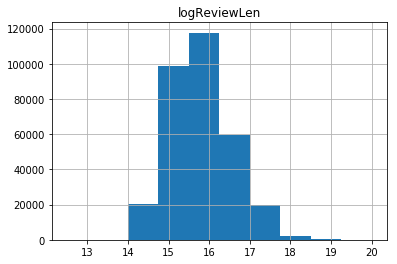

In [7]:
# vectorize Bag of Words from review text; as sparse matrix
from sklearn.feature_extraction.text import HashingVectorizer

# amazon['reviewLen'] = amazon['Text'].str.len() # Use this later /X as gross dummy

amazon['textLower'] = amazon['Text'].str.lower()
# look at the text strip_accents=ascii,  stop_words={'english'}, token_pattern = r'\b[a-zA-Z0-9]{3,}\b'),
hv0 = HashingVectorizer(n_features=2 ** 19, non_negative=True, tokenizer=LemmaTokenizer(), ngram_range=(1,3))
X_hv0 = hv0.fit_transform(amazon.textLower)


amazon['summaryFilter'] = amazon['Summary'].apply(lambda x: " " if x is np.nan else x) # some were np.nans
amazon['sfLower'] = amazon['summaryFilter'].str.lower()
# # and a second domain where we look at the summary
hv1 = HashingVectorizer(n_features=2 ** 19, non_negative=True, tokenizer=LemmaTokenizer(), ngram_range=(1,3))
X_hv1 = hv1.fit_transform(amazon.sfLower) 

# Another hash domain we want to count but not scale
# amazon['timeFilter'] = amazon['Time'].apply(lambda x: str(int(x)%(86400 * 7))) # converts to day of week
# hv2 = HashingVectorizer(n_features=2 ** 17, non_negative=True, strip_accents=ascii, 
#                            ngram_range=(1,1)) 
# X_hv2 = hv2.fit_transform(amazon.timeFilter + " " + amazon.ProductId + " " + amazon.UserId) # mw adds uid as token

amazon['logReviewLen'] = np.round(np.log(amazon['Text'].str.len()),decimals=1) + 10
amazon.hist(column="logReviewLen")

amazon['ScoreX'] = amazon['Score'].apply(lambda x: str(x)) # make score acceptable
amazon['sLogReviewLen'] = amazon['logReviewLen'].apply(lambda x: str(x)) # make score acceptable
hv2 = HashingVectorizer(n_features=2 ** 17, non_negative=True, ngram_range=(1,1)) 
X_hv2 = hv2.fit_transform(amazon.ScoreX + " " + amazon.UserId + " " + amazon.sLogReviewLen) # mw adds uid as token

import scipy.sparse as sp
X_hv = sp.hstack([X_hv0, X_hv1], format='csr')
print(X_hv.shape)

In [8]:
# x = amazon.UserId + " " +  amazon.Text
# x.head(10)

In [9]:
# We want to be able to use this model fit on other data (the test set)
# So let's save a copy of this instance of HashingVectorizer to be able to transform other data with this fit
# http://scikit-learn.org/stable/modules/model_persistence.html
joblib.dump(hv0, 'hv0.pkl') # pickle
joblib.dump(hv1, 'hv1.pkl') # pickle
joblib.dump(hv2, 'hv2.pkl') # pickle

['hv2.pkl']

In [10]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
X_tfidf = transformer.fit_transform(X_hv)

joblib.dump(transformer, 'transformer.pkl') # pickle

['transformer.pkl']

In [11]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features

In [12]:
# features from Amazon.csv to add to feature set
import re

#amazon['reviewLen'] = amazon['Text'].str.len()
#amazon['summaryLen'] = amazon['summaryFilter'].str.len()

#amazon['rlMeanDist'] = amazon['reviewLen'].apply(lambda x: abs(x-80)) # 80 is avg summary len. Thx George!
#amazon['slMeanDist'] = amazon['summaryLen'].apply(lambda x: abs(x-8)) # 8. just guessing here.

#import zlib
#amazon['nameHash'] = zlib.crc32(str(amazon['UserId']).encode('utf8'))
#amazon['nameHash'] = amazon['UserId'].apply(lambda x: zlib.crc32(str(x).encode('utf8'))) # bad. don't do it this way

# stackoverflow.com/questions/15772371/finding-average-length-of-items-in-a-list-python
# averages array element lengths
def avgLen(text, regex):
    lst = re.findall(regex, text)
    lengths = [len(i) for i in lst]
    return 0 if len(lengths) == 0 else (float(sum(lengths)) / len(lengths)) 

# ratio of regex to whole
def cRatio(text, regex):
    num = len(re.findall(regex, text))
    text = "" if text is np.nan else text
    den = len(text)
    return 0 if den == 0 else num / den

# Review Len
amazon['summaryLen'] = amazon['Text'].str.len()

# Num Words
amazon['numWords'] = amazon['Text'].apply(lambda x: len(re.findall("[a-zA-Z']+", x)))

# Num Cap Words
amazon['numCapWords'] = amazon['Text'].apply(lambda x: len(re.findall("[A-Z']+", x)))

# Avg Sentence Len
amazon['avgSenLen'] = amazon['Text'].apply(lambda x: avgLen(x, "[a-zA-Z' ]+"))

# Avg Word Len
amazon['avgWrdLen'] = amazon['Text'].apply(lambda x: avgLen(x, "[a-zA-Z']+"))

# ! Ratio
amazon['ratioBang'] = amazon['Text'].apply(lambda x: cRatio(x, "\!"))

# ? Ratio                             
amazon['ratioQmark'] = amazon['Text'].apply(lambda x: cRatio(x, "\?"))

# X_quant_features = amazon[["Score", "reviewLen", "summaryLen", "rlMeanDist", "slMeanDist"]]
# print(X_quant_features.head(10))
# print(type(X_quant_features))
X_quant_features = amazon[['summaryLen', 'numWords', 'numCapWords', 'avgSenLen', 'avgWrdLen', 'ratioBang', 'ratioQmark']]

### Combine all quantitative features into a single sparse matrix

In [ ]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr, X_hv2])  # we dont want to penalize hv2 w tfidf MW
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

### Create `X`, scaled matrix of features

In [ ]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X = sc.fit_transform(X_matrix)
print(X.shape)

joblib.dump(sc, 'sc.pkl') # pickle

### create `y`, vector of Labels

In [ ]:
y = amazon['helpful'].values
print(type(y))

### fit models

In [ ]:
from my_measures import BinaryClassificationPerformance

In [ ]:
# # MODEL: SVM, linear
# from sklearn import linear_model
# svm = linear_model.SGDClassifier()
# svm.fit(X, y)
# joblib.dump(svm, 'svm.pkl') # pickle

# svm_performance = BinaryClassificationPerformance(svm.predict(X), y, 'svm')
# svm_performance.compute_measures()
# print(svm_performance.performance_measures)

In [ ]:
# # MODEL: logistic regression
# from sklearn import linear_model
# #lgs = linear_model.SGDClassifier(loss='log', n_iter=50, alpha=0.00001)
# lgs = linear_model.SGDClassifier(loss='log', n_iter=1000, alpha=0.1)

# lgs.fit(X, y)
# joblib.dump(lgs, 'lgs.pkl') # pickle

# lgs_performance = BinaryClassificationPerformance(lgs.predict(X), y, 'lgs')
# lgs_performance.compute_measures()
# print(lgs_performance.performance_measures)

In [ ]:
# # MODEL: Naive Bayes
# from sklearn.naive_bayes import MultinomialNB
# nbs = MultinomialNB()
# nbs.fit(X, y)
# joblib.dump(nbs, 'nbs.pkl') # pickle

# nbs_performance = BinaryClassificationPerformance(nbs.predict(X), y, 'nbs')
# nbs_performance.compute_measures()
# print(nbs_performance.performance_measures)

In [ ]:
# # MODEL: Ridge Regression Classifier
# from sklearn import linear_model
# rdg = linear_model.RidgeClassifier()
# rdg.fit(X, y)
# joblib.dump(rdg, 'rdg.pkl') # pickle

# rdg_performance = BinaryClassificationPerformance(rdg.predict(X), y, 'rdg')
# rdg_performance.compute_measures()
# print(rdg_performance.performance_measures)

In [ ]:
# # MODEL: Perceptron
# from sklearn import linear_model
# prc = linear_model.SGDClassifier(loss='perceptron')
# prc.fit(X, y)
# joblib.dump(prc, 'prc.pkl') # pickle

# prc_performance = BinaryClassificationPerformance(prc.predict(X), y, 'prc')
# prc_performance.compute_measures()
# print(prc_performance.performance_measures)

In [ ]:
import json
import datetime
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB

from sklearn.neural_network import MLPClassifier # mw

# prepare a range of alpha values to test
# alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
alphas = np.array([1, 0.1, 0.01, 0.001, 0.0001, 0.00001])
Cs = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
# create and fit a ridge regression model, testing each alpha
# model = linear_model.SGDClassifier(loss='perceptron', max_iter=50) # max_iter 1000

mlp = MLPClassifier(random_state=0)
svm = linear_model.SGDClassifier(n_iter=500)
lgs = linear_model.SGDClassifier(loss='log', n_iter=500)
nbs = MultinomialNB()
rdg = linear_model.RidgeClassifier()
prc = linear_model.SGDClassifier(loss='perceptron', n_iter=500)

for model in [[svm,"svm"], [lgs,"lgs"], [prc,"prc"], [nbs,"nbs"], [rdg,"rdg"]]: 
# for model in []: 
# for model in [rdg]:    
  fh = open("GridSearch.txt", "a")
  grid = GridSearchCV(estimator=model[0], param_grid=dict(alpha=alphas), n_jobs=2) #
  grid.fit(X, y)
  print(grid)
  # summarize the results of the grid search
  print(grid.cv_results_)
  print(grid.best_score_)
  print(grid.best_estimator_.alpha)

  fh.write('\n########\n')
  fh.write(str(datetime.datetime.now()))
  fh.write('\n########\n')
  fh.write(str(model[0]) + '\n')  
  fh.write(str(grid.cv_results_).replace(", '", ",\n'") + '\n')
  fh.write(str(grid.best_score_) + '\n')  
  fh.write(str(grid.best_estimator_.alpha) + '\n')
  fh.close()

  # MODEL: BEST
  best = grid.best_estimator_

  best.fit(X, y)
  joblib.dump(best, 'best.{}.pkl'.format(model[1])) # pickle

  best_performance = BinaryClassificationPerformance(best.predict(X), y, 'best')
  best_performance.compute_measures()
  print(best_performance.performance_measures)
  

In [ ]:
'''
pg = {'learning_rate': ["constant", "invscaling", "adaptive"],
'hidden_layer_sizes': [(100,1), (100,2), (100,3)],
#'alpha': [10.0 ** -np.arange(1, 7)],
'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
'activation': ["logistic", "relu", "Tanh"],
'tol': [1e-2, 1e-4, 1e-6],
'epsilon': [1e-3, 1e-7, 1e-8, 1e-9, 1e-8]
}

fh = open("GridSearch.txt", "a")
grid = GridSearchCV(estimator=mlp, param_grid=pg, n_jobs=2) #
grid.fit(X, y)
print(grid)
# summarize the results of the grid search
print(grid.cv_results_)
print(grid.best_score_)
print(grid.best_estimator_.alpha)

fh.write('\n########\n')
fh.write(str(datetime.datetime.now()))
fh.write('\n########\n')
fh.write(str(model) + '\n')  
fh.write(str(grid.cv_results_).replace(", '", ",\n'") + '\n')
fh.write(str(grid.best_score_) + '\n')  
fh.write(str(grid.best_estimator_.alpha) + '\n')
fh.close()
'''

In [ ]:
'''
# MODEL: BEST
best = grid.best_estimator_

best.fit(X, y)
joblib.dump(best, 'best.pkl') # pickle

best_performance = BinaryClassificationPerformance(best.predict(X), y, 'best')
best_performance.compute_measures()
print(best_performance.performance_measures)
'''

### ROC plot to compare performance of various models and fits

In [ ]:
# #fits = [svm_performance, lgs_performance, nbs_performance, rdg_performance, prc_performance]
# fits = [svm_performance, lgs_performance, rdg_performance, prc_performance]

# for fit in fits:
#     plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'ro')
#     plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
# plt.axis([0, 1, 0, 1])
# plt.title('ROC plot: training set')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.show()